# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [5]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
graph_edge_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_edges.csv")

disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

,Número de nodos
bert_group,1043
complex,421
disease,15066
gene_protein,17322
pathway,2017
total,35869


,Número de enlaces
disease_disease,17432.0
form_complex,1885.0
gda,84024.0
pathway_protein,42643.0
ppi,110051.0
total,256035.0


In [9]:
enfermedades = graph_node_data[(graph_node_data.node_type == "disease")|(graph_node_data.node_type == "bert_group")]

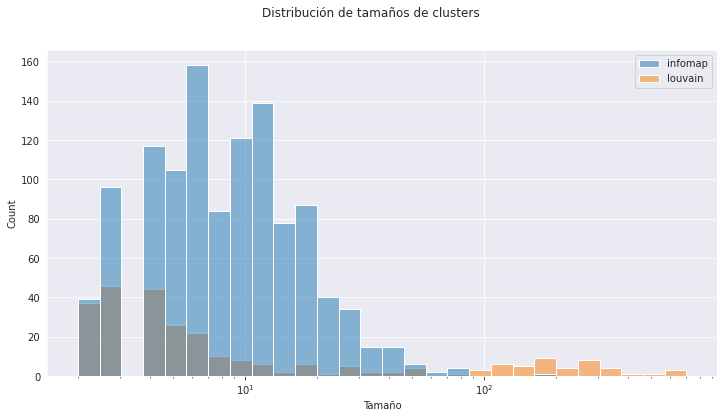

In [33]:
# fig, ax = plt.subplots(1,2,figsize=(16,6))
# fig.suptitle("Distribución de tamaños de clusters")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

# sns.histplot(data=tamaños_infomap, log_scale=True, ax=ax[0])
# ax[0].set_xlabel("Tamaño")
# ax[0].set_title("Infomap")

# sns.histplot(data=tamaños_louvain,log_scale=(False,True), ax=ax[1],bins=np.linspace(2,tamaños_louvain.max(),40))
# ax[1].set_xlabel("Tamaño")
# ax[1].set_title("Louvain")

fig2, ax2 = plt.subplots(figsize=(12,6))
sns.histplot(data=pd.DataFrame({"infomap":tamaños_infomap,"louvain":tamaños_louvain}), log_scale=True,ax=ax2, palette="tab10")
fig2.suptitle("Distribución de tamaños de clusters")
ax2.set_xlabel("Tamaño")

fig2.savefig("../../reports/analisis_comunidades/distribucion_tamaños.png", dpi=200)

Métricas de similaridad de conjuntos

In [6]:
# Unión: |, Intersección: &
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return intersection/union

def int_min(set1,set2):
    intersection = len(set1&set2)
    min_set = np.min([len(set1),len(set2)])
    return intersection/min_set

def int_max(set1,set2):
    intersection = len(set1&set2)
    max_set = np.max([len(set1),len(set2)])
    return intersection/max_set

In [10]:
comunidades_infomap = enfermedades.comunidades_infomap.dropna().astype("int").sort_values().unique()
comunidades_louvain = enfermedades.comunidades_louvain.dropna().astype("int").sort_values().unique()

In [11]:
enfermedades

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
7,7,10001_19287_23046_23048,ectodermal dysplasia syndrome,bert_group,primekg,220.0,42.0,0.0,0.0,64.0
17,17,100058_9385,hypervalinemia and hyperleucine-isoleucinemia,bert_group,primekg,463.0,36.0,0.0,0.0,2.0
19,19,10006_17723_17722_17721,Sandhoff disease,bert_group,primekg,467.0,36.0,0.0,0.0,8.0
28,28,100103_100102_100104_100101_8824,fetal akinesia deformation sequence,bert_group,primekg,367.0,17.0,0.0,0.0,2.0
88,88,100151_9066_18467,nephropathic cystinosis,bert_group,primekg,594.0,54.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...
33426,34190,C4755299,MT-ATP6-related mitochondrial spastic paraplegia,disease,disgenet,348.0,30.0,1.0,0.0,1.0
33427,34191,C4755301,Idiopathic eosinophilic myositis,disease,disgenet,568.0,9.0,0.0,0.0,1.0
33428,34192,C4755302,Focal palmoplantar keratoderma with joint kera...,disease,disgenet,236.0,42.0,1.0,0.0,1.0
33429,34194,C4755309,Diffuse palmoplantar keratoderma with painful ...,disease,disgenet,224.0,42.0,1.0,0.0,1.0


Ver matriz pero para comunidades mas grandes que determinado tamaño, para poder visualizarlo mejor.

Puedo poner en la diagonal superior la metrica con min y en la de abajo la metrica con max, para ver las dos

In [12]:
conjuntos_infomap = {int(comunidad):set(enfermedades.loc[enfermedades.comunidades_infomap == comunidad,"node_index"].values) for comunidad in comunidades_infomap}
conjuntos_louvain = {int(comunidad):set(enfermedades.loc[enfermedades.comunidades_louvain == comunidad,"node_index"].values) for comunidad in comunidades_louvain}

In [9]:
matrix_jaccard = {}
matrix_min = {}
matrix_max = {}

for comunidad_infomap,set_infomap in conjuntos_infomap.items():
    partial_jaccard = {}
    partial_min = {}
    partial_max = {}
    for comunidad_louvain, set_louvain in conjuntos_louvain.items():
        coef_jaccard = jaccard(set_infomap,set_louvain)
        coef_min = int_min(set_infomap,set_louvain)
        coef_max = int_max(set_infomap,set_louvain)
        partial_jaccard[comunidad_louvain] = coef_jaccard
        partial_min[comunidad_louvain] = coef_min
        partial_max[comunidad_louvain] = coef_max
    matrix_jaccard[comunidad_infomap] = partial_jaccard
    matrix_min[comunidad_infomap] = partial_min
    matrix_max[comunidad_infomap] = partial_max

In [10]:
df_jaccard = pd.DataFrame(matrix_jaccard)
df_min = pd.DataFrame(matrix_min)
df_max = pd.DataFrame(matrix_max)

In [15]:
nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

/tmp/ipykernel_56301/4195500612.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_56301/4195500612.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_56301/4195500612.py:26: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/tmp/ipykernel_56301/4195500612.py:40: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/tmp/ipykernel_56301/4195500612.py:53: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



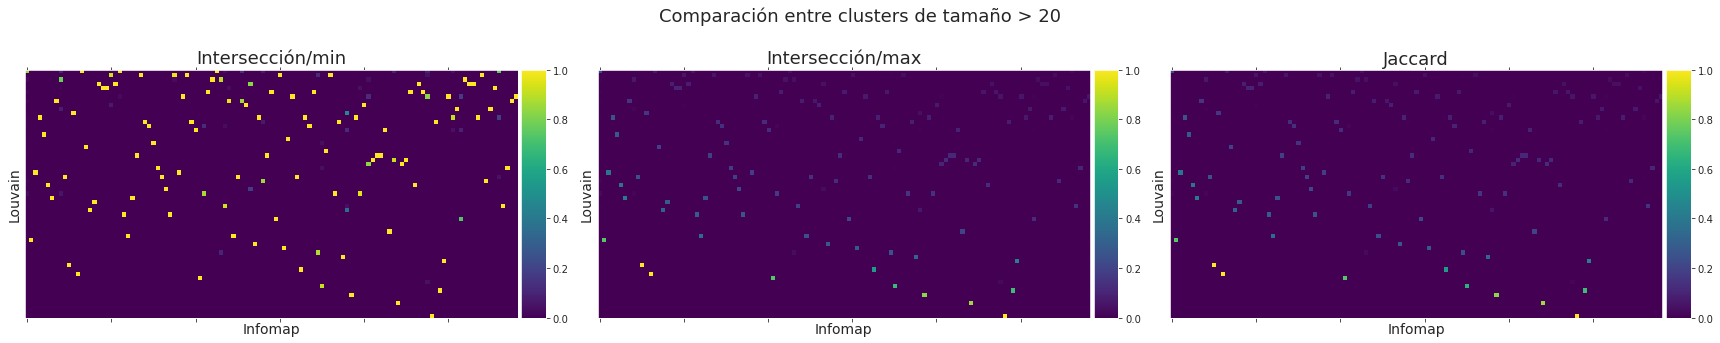

In [47]:
n = 20

infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > n].comunidad.values
louvain_corte = louvain_clusters.sort_values(by="tamaño", ascending=False)[louvain_clusters.tamaño > n].comunidad.values

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,5), sharey=True)
fig.suptitle(f"Comparación entre clusters de tamaño > {n}", fontsize=18)

jaccard_mat = df_jaccard.loc[louvain_corte,infomap_corte]
min_mat = df_min.loc[louvain_corte,infomap_corte]
max_mat = df_max.loc[louvain_corte, infomap_corte]

cmap = "viridis"

im = ax1.matshow(min_mat,
                cmap=cmap)
ax1.set_title("Intersección/min", fontsize=18)
# cbar = fig.colorbar(im, ax=ax1)
ax1.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax1.set_xlabel("Infomap", fontsize=14)
ax1.set_ylabel("Louvain", fontsize=14)
ax1.grid(False)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, ax=ax2,fraction=0.046, pad=0.04, cax=cax)


im2 = ax2.matshow(max_mat,
                cmap=cmap)
ax2.set_title('Intersección/max', fontsize=18)
# cbar = fig.colorbar(im2, ax=ax2)
ax2.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax2.set_xlabel("Infomap", fontsize=14)
ax2.set_ylabel("Louvain", fontsize=14)
ax2.grid(False)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im2, ax=ax2,fraction=0.046, pad=0.04, cax=cax2)


im3 = ax3.matshow(jaccard_mat,
                cmap=cmap)
ax3.set_title('Jaccard', fontsize=18)
ax3.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax3.set_xlabel("Infomap", fontsize=14)
ax3.set_ylabel("Louvain", fontsize=14)
ax3.grid(False)

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im3, ax=ax3,fraction=0.046, pad=0.04, cax=cax3)

plt.tight_layout()

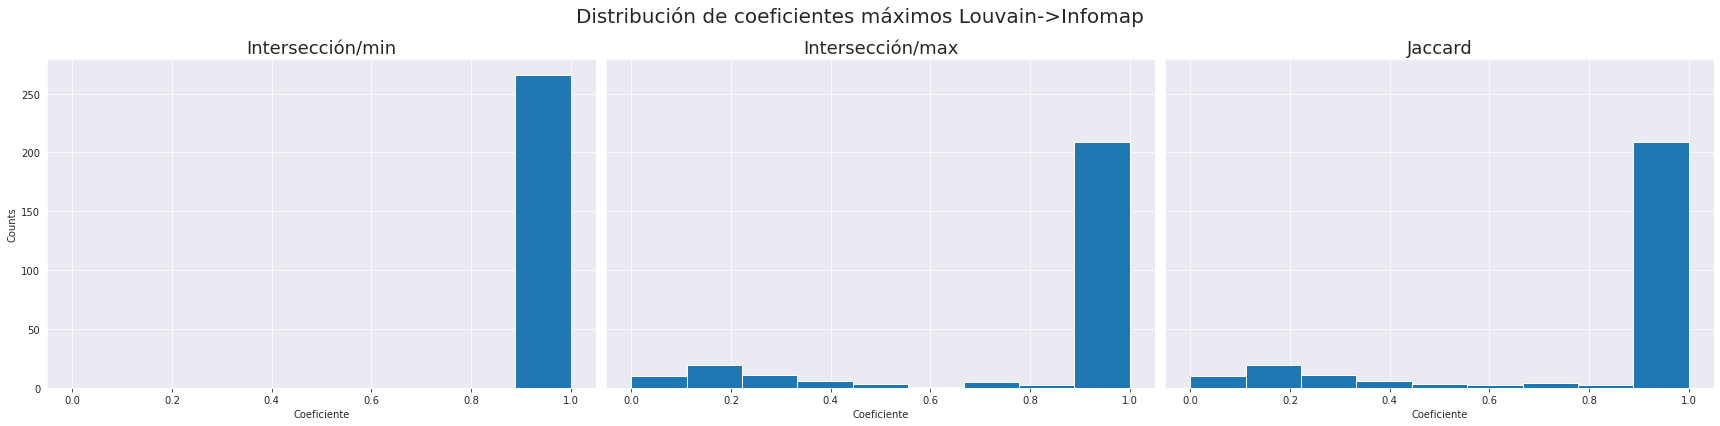

In [63]:
metricas = {"Intersección/min":df_min,"Intersección/max":df_max, "Jaccard":df_jaccard}

fig, ax = plt.subplots(1,3, figsize=(24,6), sharey=True)
fig.suptitle("Distribución de coeficientes máximos Louvain->Infomap", fontsize=20)
i=0
for name,data in metricas.items():
    ax[i].hist(data.T.max().values, bins=np.linspace(0,1,10))
    ax[i].set_title(f"{name}", fontsize=18)
    ax[i].set_xlabel("Coeficiente")
    i+=1

ax[0].set_ylabel("Counts")

plt.tight_layout()

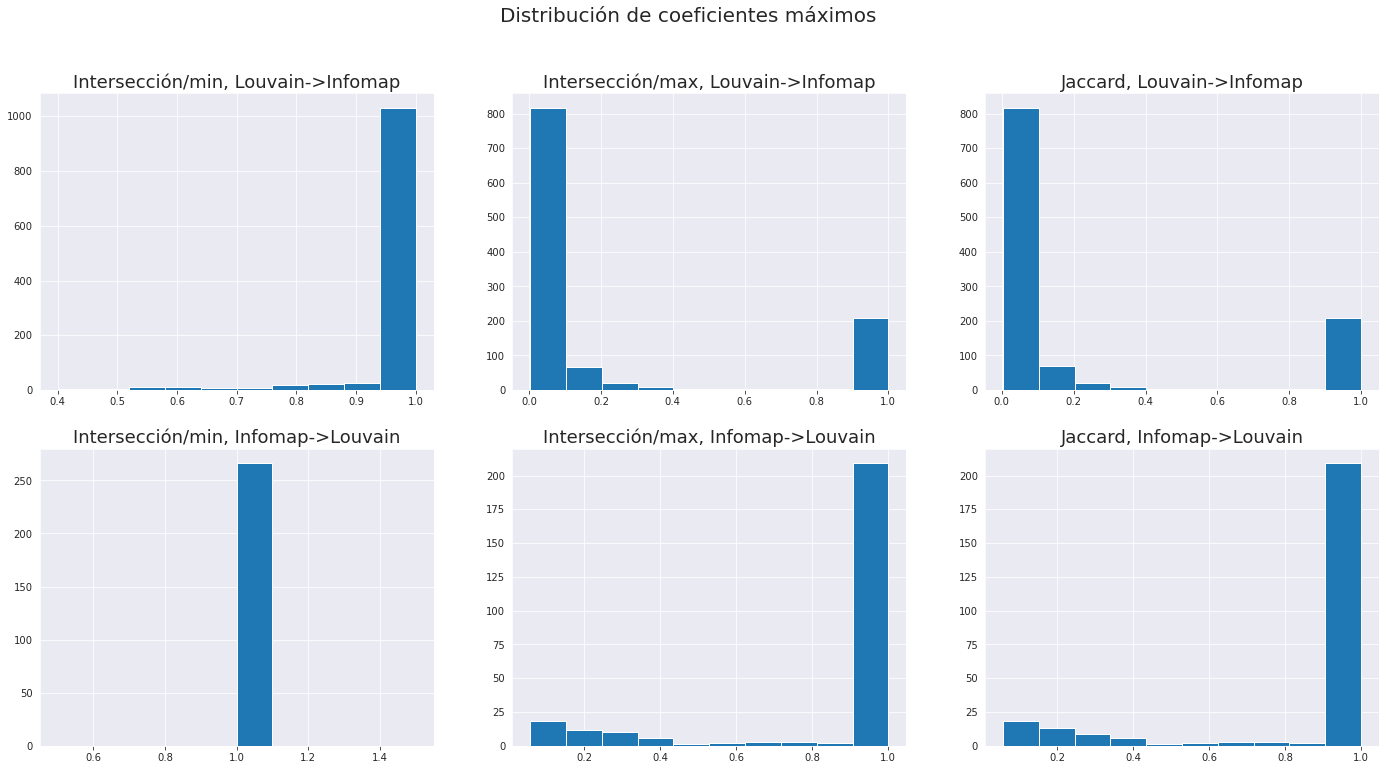

In [56]:
metricas = {"Intersección/min":df_min,"Intersección/max":df_max, "Jaccard":df_jaccard}

fig, ax = plt.subplots(2,3, figsize=(24,12))
fig.suptitle("Distribución de coeficientes máximos", fontsize=20)

i=0
for name,data in metricas.items():
    ax[0,i].hist(data.max().values)
    ax[0,i].set_title(f"{name}, Louvain->Infomap", fontsize=18)

    ax[1,i].hist(data.T.max().values)
    ax[1,i].set_title(f"{name}, Infomap->Louvain", fontsize=18)
    i+=1

# Quiero ver si las comunidades suelen tener Berts

In [16]:
bert_groups = enfermedades[enfermedades.node_type == "bert_group"]
berts_infomap = pd.DataFrame(bert_groups.comunidades_infomap.value_counts()).reset_index().rename(columns={"comunidades_infomap":"num_berts","index":"comunidad"}).astype({"comunidad":"int"})
berts_louvain = pd.DataFrame(bert_groups.comunidades_louvain.value_counts()).reset_index().rename(columns={"comunidades_louvain":"num_berts","index":"comunidad"}).astype({"comunidad":"int"})

rows_infomap = pd.DataFrame.from_dict({comunidad:0 for comunidad in comunidades_infomap if comunidad not in berts_infomap.comunidad.values},orient="index").reset_index().rename(columns={"index":"comunidad",0:"num_berts"})
rows_louvain = pd.DataFrame.from_dict({comunidad:0 for comunidad in comunidades_louvain if comunidad not in berts_louvain.comunidad.values},orient="index").reset_index().rename(columns={"index":"comunidad",0:"num_berts"})

berts_infomap = pd.concat([berts_infomap,rows_infomap])
berts_louvain = pd.concat([berts_louvain,rows_louvain])

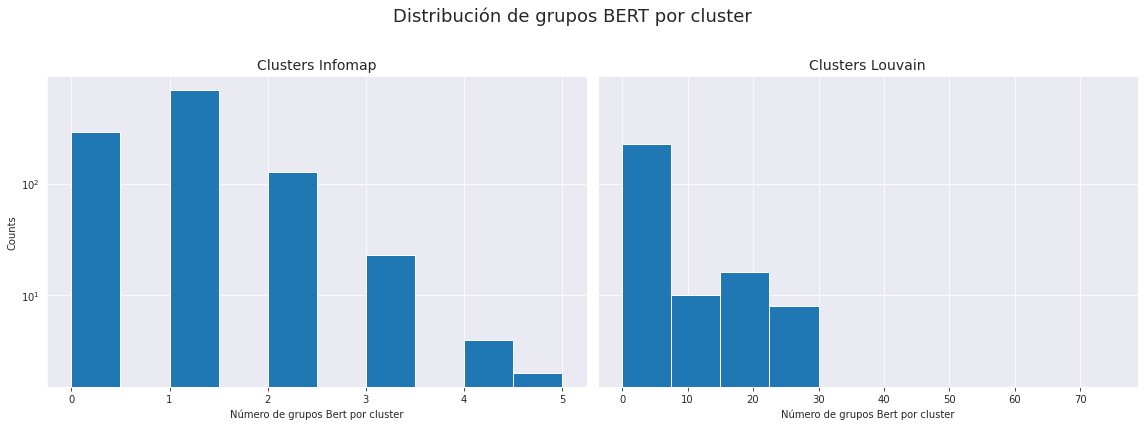

In [45]:
values_infomap = berts_infomap.num_berts.values
values_louvain = berts_louvain.num_berts.values

fig, ax = plt.subplots(1,2,figsize=(16,6), sharey=True)
fig.suptitle("Distribución de grupos BERT por cluster\n",fontsize=18)
ticks = np.logspace(0,values_louvain.max(),10)

ax[0].hist(values_infomap,log=True)
ax[0].set_title("Clusters Infomap", fontsize=14)
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Número de grupos Bert por cluster")

ax[1].hist(values_louvain,log=True)
ax[1].set_title("Clusters Louvain", fontsize=14)
ax[1].set_xlabel("Número de grupos Bert por cluster")

plt.tight_layout()

In [18]:
fig1 = px.histogram(berts_louvain["num_berts"],x="num_berts", title="Clusters Louvain",nbins=80,log_y=True)
fig1.show()

fig2 = px.histogram(berts_infomap["num_berts"],x="num_berts", title="Clusters Infomap")
fig2.show()

In [19]:
infomap_valores = berts_infomap.num_berts.value_counts()
louvain_valores = berts_louvain.num_berts.value_counts()

infomap_total = len(berts_infomap)
louvain_total = len(berts_louvain)

mas_de_uno_infomap = len(berts_infomap[berts_infomap.num_berts > 1])
mas_de_uno_louvain = len(berts_louvain[berts_louvain.num_berts > 1])

print(f"Infomap: \n{round((infomap_valores[1]*100)/infomap_total)}% de los clusters tienen un único Bert")
print(f"{round((infomap_valores[0]*100)/infomap_total)}% de los clusters no tienen ningún Bert")
print(f"{round((mas_de_uno_infomap*100)/infomap_total)}% de los clusters tiene más de un Bert\n")

print(f"Louvain: \n{round((louvain_valores[1]*100)/louvain_total)}% de los clusters tienen un único Bert")
print(f"{round((louvain_valores[0]*100)/louvain_total)}% de los clusters no tienen ningún Bert")
print(f"{round((mas_de_uno_louvain*100)/louvain_total)}% de los clusters tiene más de un Bert")

Infomap: 
61% de los clusters tienen un único Bert
26% de los clusters no tienen ningún Bert
14% de los clusters tiene más de un Bert

Louvain: 
57% de los clusters tienen un único Bert
20% de los clusters no tienen ningún Bert
23% de los clusters tiene más de un Bert


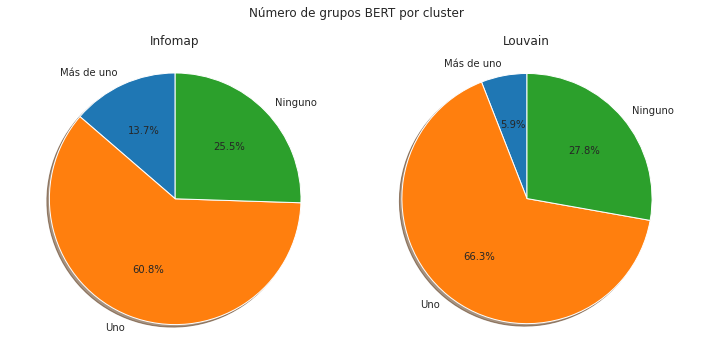

In [46]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Número de grupos BERT por cluster")

ninguno_infomap = infomap_valores[0]
unico_infomap = infomap_valores[1]

ax[0].pie([mas_de_uno_infomap,unico_infomap,ninguno_infomap], labels=["Más de uno", "Uno", "Ninguno"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[0].axis('equal') 
ax[0].set_title("Infomap")


ninguno_louvain = louvain_valores[0]
unico_louvain = louvain_valores[1]

ax[1].pie([mas_de_uno_louvain,unico_infomap,ninguno_infomap], labels=["Más de uno", "Uno", "Ninguno"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[1].axis('equal') 
ax[1].set_title("Louvain")

plt.tight_layout()

fig.savefig("../../reports/analisis_comunidades/tortas_bert.png", dpi=200)

# Veo inclusión de infomap en louvain

Hago una adaptación del coeficiente sobre mínimo, en vez de mínimo pongo infomap

In [19]:
def int_min_infomap(set_infomap,set_louvain):
    intersection = len(set_infomap&set_louvain)
    min_set = len(set_infomap)
    return intersection/min_set

In [22]:
matrix_min_infomap = {}

for comunidad_infomap,set_infomap in conjuntos_infomap.items():
    partial_min_infomap = {}
    for comunidad_louvain, set_louvain in conjuntos_louvain.items():
        coef_min_infomap = int_min_infomap(set_infomap,set_louvain)
        partial_min_infomap[comunidad_louvain] = coef_min_infomap
    matrix_min_infomap[comunidad_infomap] = partial_min_infomap

df_min_infomap = pd.DataFrame(matrix_min_infomap)

/tmp/ipykernel_29713/145107736.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > n].comunidad.values
/tmp/ipykernel_29713/145107736.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  louvain_corte = louvain_clusters.sort_values(by="tamaño", ascending=False)[louvain_clusters.tamaño > n].comunidad.values


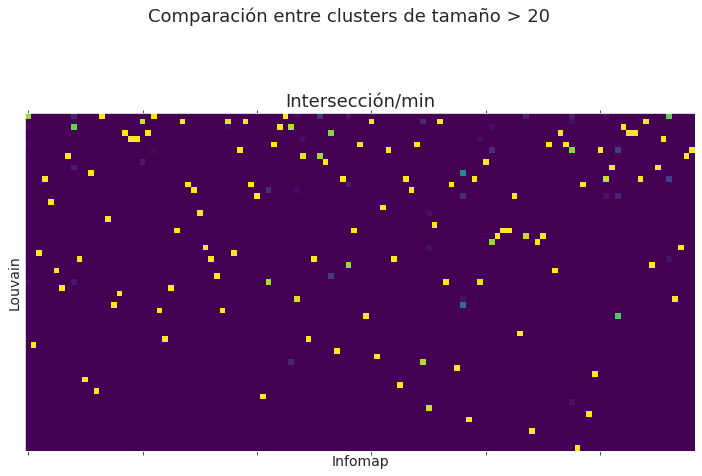

In [41]:
n = 20

infomap_corte = infomap_clusters.sort_values(by="tamaño", ascending=False)[infomap_clusters.tamaño > n].comunidad.values
louvain_corte = louvain_clusters.sort_values(by="tamaño", ascending=False)[louvain_clusters.tamaño > n].comunidad.values

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle(f"Comparación entre clusters de tamaño > {n}", fontsize=18)

min_infomap_mat = df_min_infomap.loc[louvain_corte,infomap_corte]

cmap = "viridis"

im = ax.matshow(min_infomap_mat,
                cmap=cmap)
ax.set_title("Intersección/min", fontsize=18)
# cbar = fig.colorbar(im, ax=ax1)
ax.tick_params(labelbottom=False, labelleft=False,labeltop=False)
ax.set_xlabel("Infomap", fontsize=14)
ax.set_ylabel("Louvain", fontsize=14)
ax.grid(False)

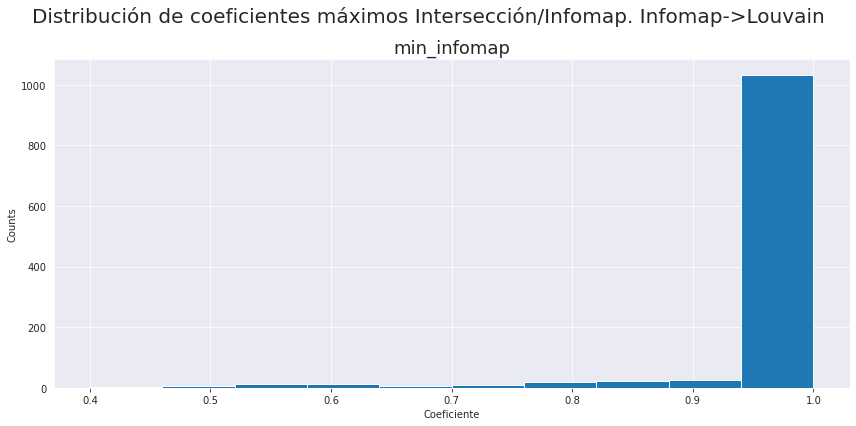

In [59]:
data = df_min_infomap
name = "min_infomap"

fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle("Distribución de coeficientes máximos Intersección/Infomap. Infomap->Louvain", fontsize=20)
i=0

ax.hist(data.max().values)
ax.set_title(f"{name}", fontsize=18)
ax.set_xlabel("Coeficiente")
ax.set_ylabel("Counts")

plt.tight_layout()
# plt.savefig("../../../reports/analisis_comunidades/interseccion_infomap.png", dpi=200)